# Intro Deep Learning Notebook
This notebook demonstrates how to actually implement the ideas discussed in the presentation.

## Step 1: Imports
There are two main frameworks used for deep learning in a research setting: [Pytorch](https://pytorch.org/) and [Tensorflow](https://www.tensorflow.org/). 
Because the code for these frameworks can be verbose, there are also libraries that abstract away many implementation details such as [Keras](https://keras.io), [fastai](https://fast.ai), and
[HuggingFace](https://huggingface.co/).

Picking your framework is usually easy: you just select a model from the literature that worked well
on your problem, then modify it to do what you want.
If you have to start from scratch, use the highest level library that will do what you want.
That is to say, pick Keras or fastai before Tensorflow or Pytorch whenever possible.

I've selected Pytorch because I'm familiar with it, and because the model I'm using in the next presentation is a Pytorch model.

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# Make code deterministic
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# First column is the label, other 784 columns are pixel values
numbers_df = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
numbers_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19997,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19998,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 2: Data

Pytorch uses Dataset objects to store their data, and DataLoader objects to feed the
data into models.

In [4]:
class MnistDataset(Dataset):
  """ This Dataset object stores the MNIST handwritten digit dataset """ 
  def __init__(self, csv_path: str) -> None:
    """ An intializer function that reads the csv stored at csv_path """
    numbers_df = pd.read_csv(csv_path, header=None)

    # Pull the labels and data out of the pandas dataframe and into numpy arrays
    self.labels = numbers_df.iloc[:,0].values
    self.pixels = numbers_df.iloc[:,1:].values
  
  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """ Retrieve the item in the dataset at index idx """
    return self.pixels[idx,:], self.labels[idx]

  def __len__(self) -> int:
    """ Return the number of items in the dataset """
    return len(self.labels)

In [5]:
# These MNIST file are built into colab, but you can also download them and change the paths
# to run this notebook locally with Jupyter
train_dataset = MnistDataset('/content/sample_data/mnist_train_small.csv')
train_dataset, val_dataset = random_split(train_dataset, [18000, 2000], torch.Generator().manual_seed(42))
test_dataset = MnistDataset('/content/sample_data/mnist_test.csv')

9
5
7


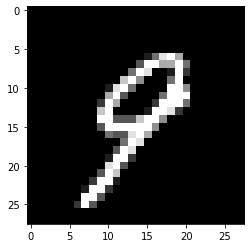

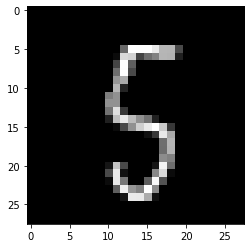

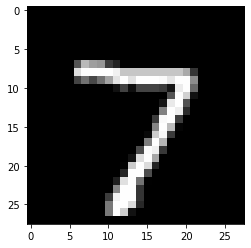

In [6]:
images = []
for dataset in [train_dataset, val_dataset, test_dataset]:
  pixels, label = dataset[0]

  # Reshape the long flat vector of pixel values into a square image
  img_example = np.reshape(pixels, [28, 28])
  print(label)
  plt.figure()
  plt.imshow(img_example, cmap="gray")

In [7]:
# Pytorch uses objects called DataLoaders to feed data into models.
# Dataloaders handle details like data shuffling and how many items to include per batch
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

## Step 3: Model
We'll create a simple fully connected network model that takes in images and predicts which digit they represent

In [8]:
class FullyConnectedNetwork(nn.Module):
  """ A neural network designed to predict which digit is depicted in an image """
  def __init__(self):
    """ This function initializes the layers for the network """
    # Call the nn.Module init function
    super(FullyConnectedNetwork, self).__init__()
  
    # Create the neural network layers
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, pixels: torch.Tensor):
    """ 
    The forward function takes an image or batch of images as the input and returns 
    the predicted probability of each class (digit)
    """
    # Feed pixels into first fully connected layer
    x = self.fc1(pixels)

    # Apply the ReLU nonlinearity
    x = F.relu(x)
    
    # Feed the output of the first layer into the second layer
    x = self.fc2(x)

    # Apply a softmax to scale the outputs to be between 0 and 1 and sum to 1 
    x = F.softmax(x, dim=-1)
  
    return x

In [9]:
model = FullyConnectedNetwork()

example, label = train_dataset[0]
print(model(torch.Tensor(example)))
pred = torch.argmax(model(torch.Tensor(example)))
print('An untrained model predicted {}, but the real number was {}'.format(pred, label))

tensor([2.3221e-11, 6.7203e-34, 2.3421e-26, 1.4276e-25, 1.6089e-37, 9.9330e-23,
        1.6785e-19, 5.6315e-28, 1.0000e+00, 4.5462e-28],
       grad_fn=<SoftmaxBackward>)
An untrained model predicted 8, but the real number was 9


## Step 4: Training
Now we'll train the model to make better predictions

In [10]:
model = FullyConnectedNetwork()

# Create the loss and optimizer
loss_fn = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters())

# An epoch is the number of iterations it takes for the model to see every training point once
epochs = 10
for epoch in range(epochs):
  for i, batch in enumerate(train_loader):
    images, labels = batch
    images = images.float()

    # Zero out the gradient on the optimizer
    optimizer.zero_grad()
    output = model(images)
    loss = loss_fn(output, labels)
    
    # Tell the optimizer to calculate the gradient of the loss function
    loss.backward()
    
    # Update the model's weights
    optimizer.step()

  num_correct = 0
  for batch in val_loader:
    image, label = batch
    image = image.float()

    output = model(image)
    prediction = np.argmax(output.detach().numpy())
    if prediction == label:
      num_correct += 1
  print('Val acc = {}'.format(num_correct / len(val_dataset)))

    


Val acc = 0.4815
Val acc = 0.511
Val acc = 0.527
Val acc = 0.5235
Val acc = 0.5415
Val acc = 0.525
Val acc = 0.5205
Val acc = 0.5385
Val acc = 0.5415
Val acc = 0.52


## Step 5: Evaluation
Finally, we'll measure the trained model's performance on a held-out test set. The test set measures the final model's ability to make predictions on data it hasn't seen before.

In [11]:
num_correct = 0
for batch in test_loader:
    image, label = batch
    image = image.float()

    output = model(image)
    prediction = np.argmax(output.detach().numpy())
    if prediction == label:
      num_correct += 1

print('Test accuracy: {}'.format(num_correct / len(test_dataset)))

Test accuracy: 0.5275
